# Homework 21
## Section 4.4
## Logan Schelly
## Math 402
## Fall 2019


In [1]:
import numpy as np
from scipy import stats
from scipy import integrate
from matplotlib import pyplot as plt

### Exercise 4.21
Consider the p.d.f. $f(x) = \frac{1}{4} \sum_{k=1}^{4}\phi(x - 3k)$ where $\phi(x)$ is the p.d.f. for the standard normal distribution.

#### Part (i)
One can draw from the distribution defined by $f$ by first choosing a value of $k$ uniformly from $\{1, 2, 3, 4\}$ and then drawing $z$ from the standard normal distribution and letting $x = z + 3k$.  Numerically draw from this distribution $n = 1000$ times and call the result $\mathbf{x} = (x_1, x_2, \ldots, x_n)$.

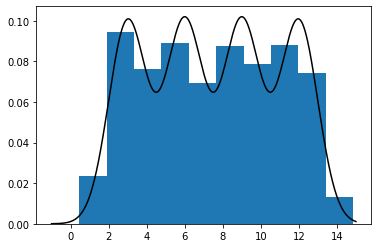

In [2]:
totally_random_string = 'cglover52'
base_36_int = int(totally_random_string, base=36)
my_super_random_seed = base_36_int % (2 ** 32)
np.random.seed(my_super_random_seed)

Z = stats.norm()
K = stats.randint(low=1, high=4+1)
n = 1000
x = Z.rvs(n) + 3 * K.rvs(n)

#Look at a histogram compared to the p.d.f, just to make sure we're drawing properly.
plt.hist(x, density=True)

f = lambda t : Z.pdf(t - 3 * np.arange(1,5).reshape((4, -1))).mean(axis=0)
t = np.linspace(-1, 15, 1000)
plt.plot(t, f(t), 'k')
plt.show()

#### Part (ii)
Let $a = \text{min}(x_1, \ldots, x_n)$ and $b = \text{max}(x_1, \ldots, x_n)$.  For each value of $m \in \{1, 6, 11, 16, \ldots, 46\}$ plot the histogram for $\mathbf{x}$ on $(a,b]$ with $m$ bins, and plot the p.d.f. $f(x)$ on each of these histograms for comparison.

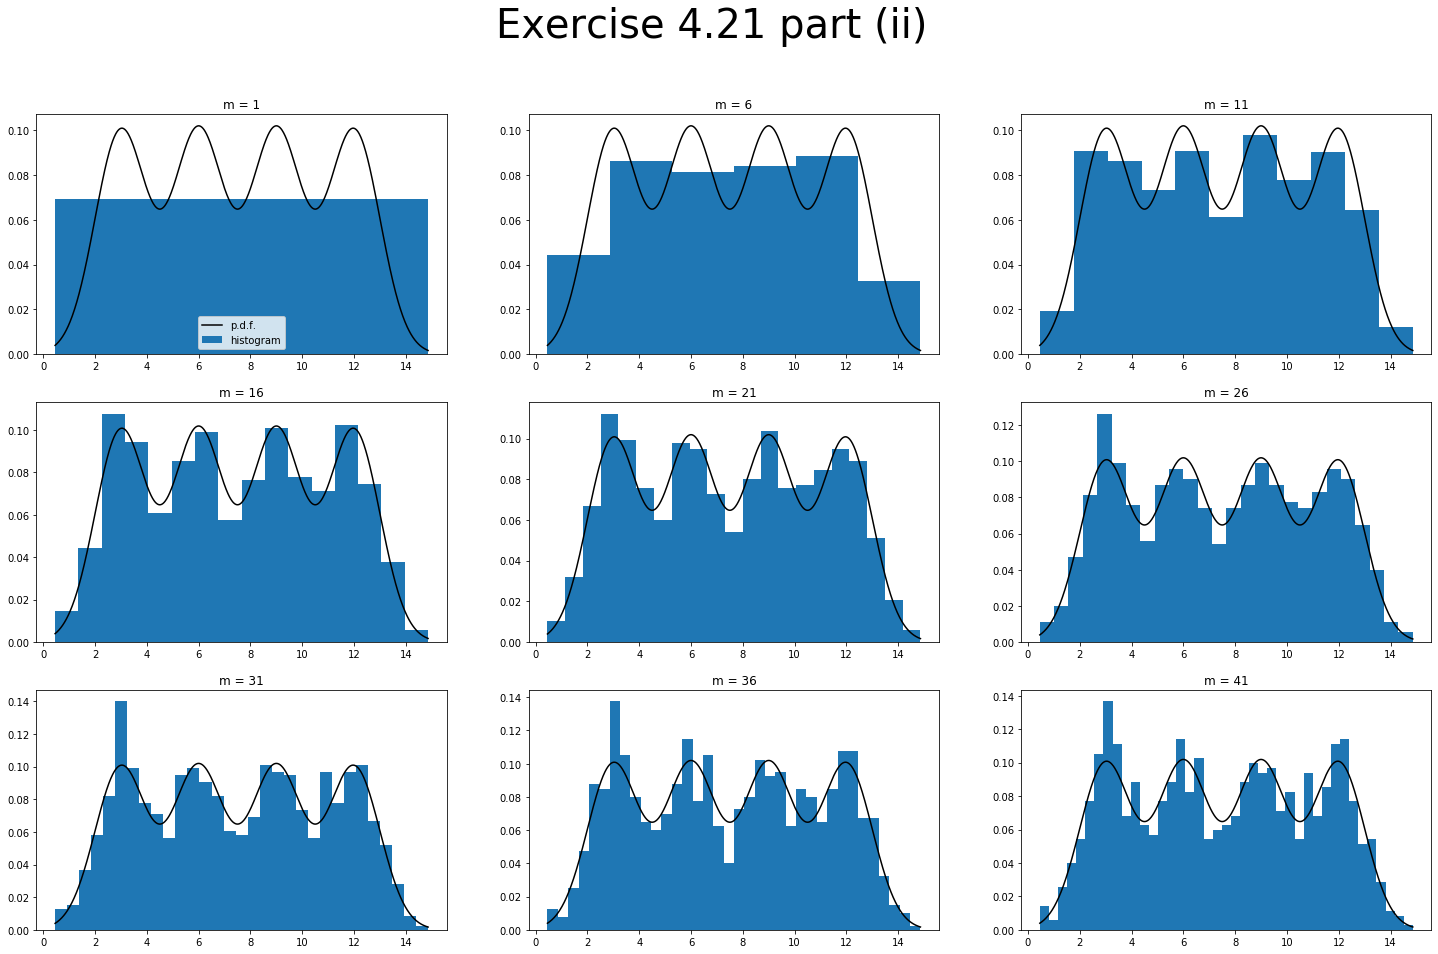

In [3]:
a = x.min()
b = x.max()
m_values = np.arange(1, 47, 5)
fig, subplots = plt.subplots(nrows = 3, ncols = 3, figsize=(25, 15))

t = np.linspace(a, b, 1000)

for m, sbplt in zip(m_values, subplots.ravel()):
    sbplt.set_title("m = {}".format(m))
    sbplt.plot(t, f(t), 'k', label = 'p.d.f.')
    sbplt.hist(x, bins=m, label = 'histogram', density=True)
    if m==1:
        sbplt.legend()

plt.suptitle("Exercise 4.21 part (ii)", fontsize=40)
plt.show()

#### Part (iii)
Compute the Freedman-Draconis binwidth $h$ for $\mathbf{x}$:
$$
h = 2 \frac{\text{IQR}(x)}{\sqrt[3]{n}}
$$
where IQR = $Q_3 - Q_1$ is the interquartile range and $Q_i = \inf\left\{x | \frac{i}{4} \leq \hat{F}_{\mathbf{x}}(x)\right\}$.

In [4]:
IQR = stats.iqr(x) #Good ol' SciPy.
h = 2 * IQR * n**(-1/3)
m = int(round((b-a)/h))

#Double-check against the python method for Freedman-Draconis.
np_fd_bins = np.histogram_bin_edges(x, bins='fd')

Plot the histogram on $(a,b]$ with that bindwidth (or rather with $m \in \mathbb{Z} \approx \frac{b-a}{h}$).

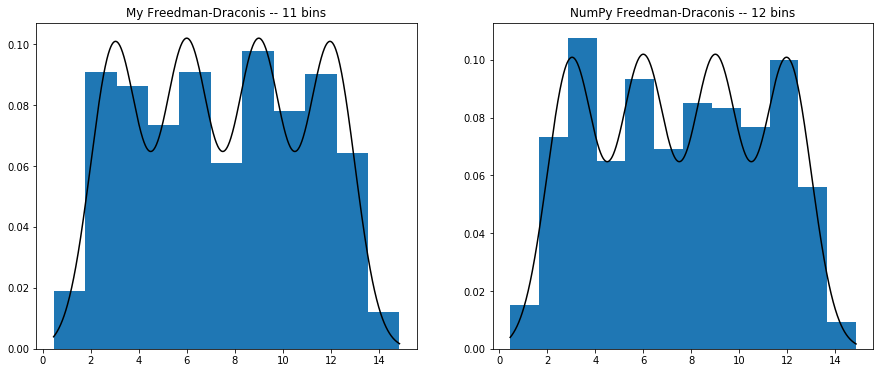

In [5]:
fig, subplots = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

subplots[0].set_title("My Freedman-Draconis -- {} bins".format(m))
subplots[0].hist(x, bins=m, density=True)
subplots[0].plot(t, f(t), 'k')

subplots[1].set_title("NumPy Freedman-Draconis -- {} bins".format(np_fd_bins.size-1))
subplots[1].hist(x, bins=np_fd_bins, density=True)
subplots[1].plot(t, f(t), 'k')

plt.show()

#### Part (iv)
For each value of $m\in \{1, 6, 11, 16, \ldots, 46\}$ compute the leave-one-out cross-validation estimate of the ISE, and identify the optimal value of $m$. Hint: consider using Proposition 4.4.11: for a histogram with $m$ bins of width $h$, the leave-one-out cross-validation estimator $\widehat{ISE}(\hat{f}_{\mathbf{x}}, f)$ is
$$
\frac{2}{h(n-1)} - \frac{n+1}{h(n-1)}\sum_{j=1}^{m} \hat{p}_j^2
$$
where $p_j$ is the percentage of $X_i$'s that lie in the $j$th bin.

Note: $\widehat{ISE}(\hat{f}_{\mathbf{x}}, f)$ can be negative.  It ignores the $\int f(x)^2 dx$ term from the ISE formula.

In [6]:
best_error = np.inf
best_m = None
ISE_estimates = list()

for m in m_values:
    counts, bin_edges = np.histogram(x, bins=m)
    p_hat = counts/n
    h = (b-a)/m
    ISE_estimate = 2/(h*(n-1)) - ((n+1) / (h*(n-1))) * sum(p_hat**2)
    if ISE_estimate < best_error:
        best_error = ISE_estimate
        best_m = m
    ISE_estimates.append(ISE_estimate)
    
print("The best m was {0} with ISE estimate {1}.".format(best_m, best_error))

The best m was 16 with ISE estimate -0.08034204192026022.


#### Part (v)
For each value of $m \in \{1, 6, 11, 16, \ldots, 46\}$ compute the actual value of $ISE(\hat{f}_{\mathbf{x}}, f)$ and compare to the corresponding leave-one-out cross-validation estimates.  Hint: you know $f$ in this case.  You may need to code up and implementation of the function $\hat{f}_{\mathbf{x}}$ and use numerical integration techniques to compute the integrals.

##### Note:
Since we already know that $\widehat{ISE}(\hat{f}_n, f)$ estimates $ISE(\hat{f}_n, f) - \int f(x)^2 dx$, I'm actually going to compute
$$
ISE(\hat{f}_n, f) - \int f(x)^2 dx = \int\hat{f}_n(x)^2 - 2 \hat{f}_n(x)f(x)dx
$$
and compare that to the corresponding leave-one-out cross-validation estimates.

In [7]:
class histogram_func():
    """
    This is really just a helper class for this specific problem.
    Models a histogram function.
    """
    
    def from_sample(sample, nbins):
        return histogram_func(*np.histogram(sample, bins=nbins))
    
    def __init__(self, counts, bin_edges):
        self.counts = counts
        self.percentage = counts/sum(counts)
        self.bin_edges = bin_edges
        
    def __call__(self, x):
        
        #Find the index where each input belongs in the bins.
        bin_indices = np.digitize(x, self.bin_edges) - 1
        
        #Return the value of the corresponding bin.
        retvals = np.zeros_like(x)
        
        #Mask all the stuff outside the bin range
        mask = ((bin_indices < self.percentage.size) & (bin_indices >= 0))
        retvals[mask] = self.percentage[bin_indices[mask]] 
        
        return retvals

#Iterate through the bin widths.
for m, ISE_estimate in zip(m_values, ISE_estimates):
    
    #Numerically approximate the integral.
    f_hat_n = histogram_func.from_sample(x, nbins=m)
    integrand = lambda t : f_hat_n(t) * (f_hat_n(t) - 2 * f(t))
    shifted_ISE, err = integrate.quad(integrand, a, b, points = f_hat_n.bin_edges)
    
    print("\tNumber of bins:", m)
    print("{:1.10f} is the leave-one-out cross-validation estimate".format(ISE_estimate))
    print("{:1.10f} is the value we got with quadrature.".format(shifted_ISE))
    print("{:1.16f} is the difference.".format(ISE_estimate - shifted_ISE))
    print()



	Number of bins: 1
-0.0694515361 is the leave-one-out cross-validation estimate
12.4023586275 is the value we got with quadrature.
-12.4718101635339274 is the difference.

	Number of bins: 6
-0.0759695281 is the leave-one-out cross-validation estimate
0.0761913776 is the value we got with quadrature.
-0.1521609057080491 is the difference.

	Number of bins: 11
-0.0791201712 is the leave-one-out cross-validation estimate
-0.0713560408 is the value we got with quadrature.
-0.0077641304510925 is the difference.

	Number of bins: 16
-0.0803420419 is the leave-one-out cross-validation estimate
-0.0795428312 is the value we got with quadrature.
-0.0007992107101527 is the difference.

	Number of bins: 21
-0.0796434910 is the leave-one-out cross-validation estimate
-0.0728836443 is the value we got with quadrature.
-0.0067598467023346 is the difference.

	Number of bins: 26
-0.0792461281 is the leave-one-out cross-validation estimate
-0.0650133490 is the value we got with quadrature.
-0.0142327

### Exercise 4.22
For the same sample $\mathbf{x}$ used in the previous problem...
#### Part (i)
For each value of $h \in \{2^{-3}, 2^{-2}, 2^{-1}, 2^0, 2^1, 2^2\}$ plot the $KDE$ for the sample with the 
Epanechnikov kernel and plot the p.d.f. $f(x)$ on each of these KDEs for comparison.  Hint: unless your numerical system already has the Epanechnikov KDE built in, you may need to code up an implementation of the KDE $\hat{f}_{\mathbf{x}}$.

In [8]:
#You think I might have to code up the Epanechnikov KDE?  Joke's on you.  I know how to Google.
from sklearn.neighbors.kde import KernelDensity

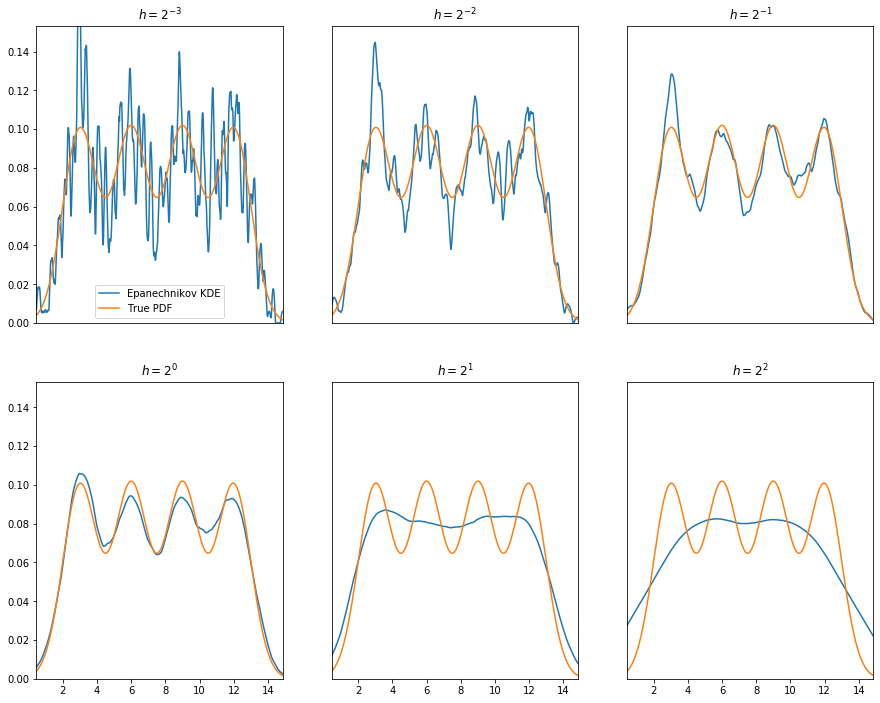

In [9]:
fig, subplots = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))

for i, (h, sbplt) in enumerate(zip(2.**np.arange(-3, 3), subplots.ravel())):
    
    #Make a scikit-learn model.  Scikit likes things as column vectors for some reason.
    kde = KernelDensity(kernel='epanechnikov', bandwidth=h).fit(x.reshape((-1,1)))
    
    #Calculate the points on the plot.  Again, Scikit likes columns vectors.
    log_probs = kde.score_samples(t.reshape((-1,1))) #score_samples gives the log pdf.
    sbplt.plot(t, np.exp(log_probs), label='Epanechnikov KDE')
    sbplt.plot(t, f(t), label = "True PDF")
    
    #Pretty up the plot.
    exponent = int(round(np.log2(h)))
    sbplt.set_title("$h = 2^{%d}$"%(exponent))
    sbplt.set_xlim((a, b))
    sbplt.set_ylim((0, 1.5*f(t).max()))
    
    #Only put a legend on the top left plot.
    if i == 0:
        sbplt.legend()
    #Only put vertical tickmarks on the leftmost plots.
    if i%3 != 0:
        sbplt.set_yticks([])
    #Only put horizontal tickmarks on the bottom plots.
    if i < 3:
        sbplt.set_xticks([])

plt.show()

#### Part (ii)
Plot the KDE for $\mathbf{x}$ with the bandwidth
$$
h = 1.059\hat{\sigma}_{\mathbf{x}} n^{-\frac{1}{5}}
$$
where $\hat{\sigma}_{\mathbf{x}}$ is the sample standard deviation (the square root of the biased sample variance.)


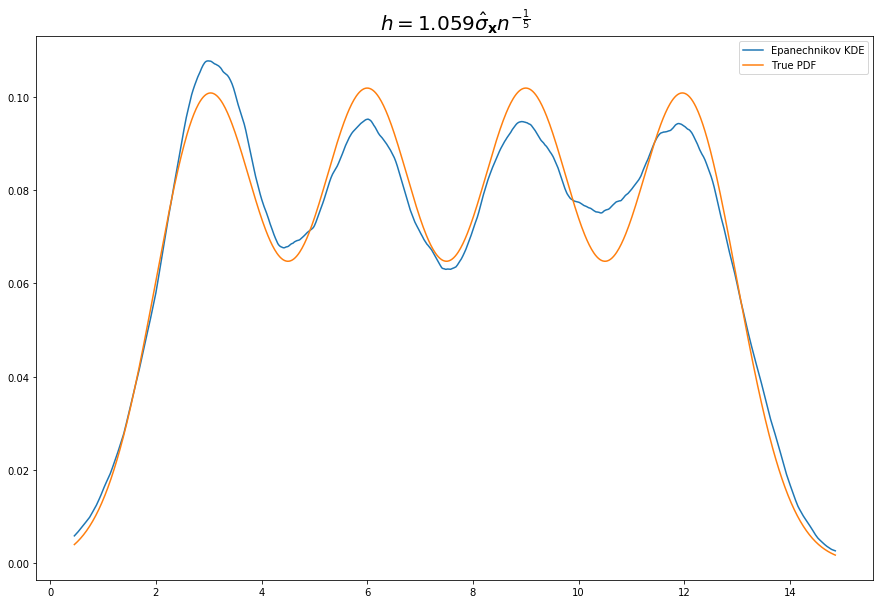

h was 0.9391401369476551


In [10]:
h = 1.059 * x.std() * n**(-1/5)

#Make a scikit-learn model.  Scikit likes things as column vectors for some reason.
kde = KernelDensity(kernel='epanechnikov', bandwidth=h).fit(x.reshape((-1,1)))

#Calculate the points on the plot.  Again, Scikit likes columns vectors.
plt.figure(figsize=(15, 10))

log_probs = kde.score_samples(t.reshape((-1,1))) #score_samples gives the log pdf.
plt.plot(t, np.exp(log_probs), label='Epanechnikov KDE')
plt.plot(t, f(t), label = "True PDF")

plt.legend()
plt.title(r"$h = 1.059 \hat{\sigma}_{\mathbf{x}} n^{-\frac{1}{5}}$", fontsize = 20)
plt.show()
print("h was", h)

#### Part (iii)
For each value of  $h \in \{2^{-3}, 2^{-2}, 2^{-1}, 2^0, 2^1, 2^2\}$, compute the actual value of $ISE(\hat{f}_{\mathbf{x}}, f)$ for the Epanechnikov KDE with bandwidth $h$.  Hint: you know $f$, but you may need to use numerical integration techniques to compute the integrals.

In [15]:
for exponent in range(-3, 3):
    h = 2.**exponent
    
    #Make a scikit-learn model.
    kde = KernelDensity(kernel='epanechnikov', bandwidth=h).fit(x.reshape((-1,1)))
    
    #Define f_hat_x
    f_hat_x = lambda t : np.exp(kde.score_samples(np.array(t).reshape((-1,1))))
    integrand = lambda t : (f_hat_x(t) - f(t))**2
    
    #We'll not be smooth at the spots where the parabola hits the x-axis.  Use those for the integration samples.
    s = np.hstack((x, x-h, x+h))
    s = s[(s >= a) & (s <= b)] #Hack off the points outside the domain.
    s.sort()
    ISE = integrate.simps(integrand(s), x=s)
    
    print("When h = 2**({0:2}) the ISE is {1:2.5f}".format(exponent, ISE))

When h = 2**(-3) the ISE is 0.00499
When h = 2**(-2) the ISE is 0.00177
When h = 2**(-1) the ISE is 0.00062
When h = 2**( 0) the ISE is 0.00038
When h = 2**( 1) the ISE is 0.00231
When h = 2**( 2) the ISE is 0.00483
